<a href="https://colab.research.google.com/github/manisharavindh/basic-pytorch-models/blob/main/notebooks/03_multiclass_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import torch
from torch import nn
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

print(torch.__version__)

2.6.0+cu124


In [59]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

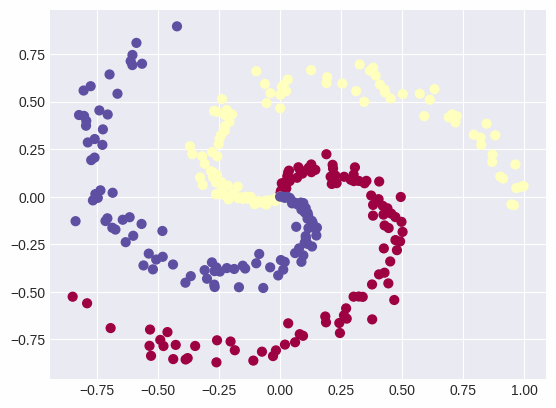

In [60]:
# spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [61]:
# data to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [62]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# model
from torch import nn

class SpiralModel(nn.Module):
  def __init__(self, input_units, output_units, hidden_units=16):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=input_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_units)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

model = SpiralModel(input_units=2, output_units=3, hidden_units=16).to(device)
model

SpiralModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [64]:
# !pip install torchmetrics

In [65]:
# loss, optimizer and acc
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

from torchmetrics import Accuracy
acc_fn = Accuracy(task='multiclass', num_classes=3).to(device)

In [66]:
# training loop
torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc*100:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc*100:.2f}%")

Epoch: 0 | Loss: 1.11233 | Acc: 32.50% | Test Loss: 1.07680 | Test Acc: 36.67%
Epoch: 100 | Loss: 0.04491 | Acc: 98.75% | Test Loss: 0.02073 | Test Acc: 100.00%
Epoch: 200 | Loss: 0.02304 | Acc: 99.17% | Test Loss: 0.00193 | Test Acc: 100.00%
Epoch: 300 | Loss: 0.01770 | Acc: 99.17% | Test Loss: 0.00038 | Test Acc: 100.00%
Epoch: 400 | Loss: 0.01582 | Acc: 99.17% | Test Loss: 0.00024 | Test Acc: 100.00%
Epoch: 500 | Loss: 0.01511 | Acc: 99.17% | Test Loss: 0.00014 | Test Acc: 100.00%
Epoch: 600 | Loss: 0.01489 | Acc: 99.17% | Test Loss: 0.00011 | Test Acc: 100.00%
Epoch: 700 | Loss: 0.01430 | Acc: 99.17% | Test Loss: 0.00011 | Test Acc: 100.00%
Epoch: 800 | Loss: 0.01429 | Acc: 99.17% | Test Loss: 0.00007 | Test Acc: 100.00%
Epoch: 900 | Loss: 0.01428 | Acc: 99.17% | Test Loss: 0.00006 | Test Acc: 100.00%


In [67]:
# predictions
model.eval()
with torch.inference_mode():
  y_preds = torch.softmax(model(X_test), dim=1).argmax(dim=1)

y_preds[:5], y_test[:5]

(tensor([2, 2, 1, 0, 2]), tensor([2, 2, 1, 0, 2]))

In [68]:
# data visualization imports
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists, skipping download!")
else:
  print("downloading helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download!


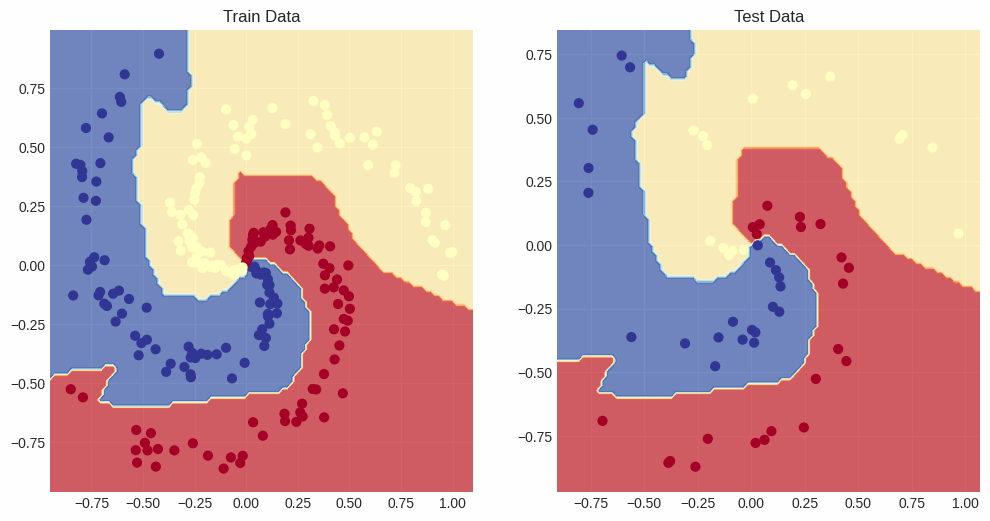

In [69]:
# plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train Data')
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test Data')
plot_decision_boundary(model, X_test, y_test)

In [70]:
# saving the model
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_multiclass_classification_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(
    obj=model.state_dict(),
    f=MODEL_SAVE_PATH
)
print(f"model saved to: {MODEL_SAVE_PATH}")

model saved to: models/03_multiclass_classification_model.pth
